# Capstone 2 Modeling (hour)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [395]:
#load python packages
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from IPython.display import Image
from tbats import BATS, TBATS
%matplotlib inline

In [12]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
dfts = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\dfts.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
dfts.index = pd.to_datetime(dfts.index)
# set the index frequency
df2.index.freq="D"
df6.index.freq="D"
df7.index.freq="D"

In [13]:
# dfts doesn't have 24 hours, so we will reindex it and fill in the missing hours with 0
dfts24 = dfts.reindex(pd.date_range('2016-01-04', periods=17472, freq='h'), fill_value=0)
# check for total number of hours
display(len(dfts24))
# check and see if there's NaN and date range are what we want
display(dfts24.isnull().any())
display(dfts24.head())
display(dfts24.tail())

17472

sales    False
dtype: bool

,sales
2016-01-04 00:00:00,0.0
2016-01-04 01:00:00,0.0
2016-01-04 02:00:00,0.0
2016-01-04 03:00:00,0.0
2016-01-04 04:00:00,0.0


,sales
2017-12-31 19:00:00,18.980000
2017-12-31 20:00:00,91.013462
2017-12-31 21:00:00,86.495385
2017-12-31 22:00:00,61.535769
2017-12-31 23:00:00,0.000000


In [14]:
# make a hourly time series dataframe for 2016
dfts2016 = dfts24.iloc[:8736]
dfts2016.index.freq="H" #set time series index frequency to hourly
dfts2016 #note we included 1/1 of 2017 to make it total of 364 days

,sales
2016-01-04 00:00:00,0.00
2016-01-04 01:00:00,0.00
2016-01-04 02:00:00,0.00
2016-01-04 03:00:00,0.00
2016-01-04 04:00:00,0.00
...,...
2017-01-01 19:00:00,85.69
2017-01-01 20:00:00,62.06
2017-01-01 21:00:00,117.45
2017-01-01 22:00:00,89.25


In [15]:
# 2017 will be the remaining and should be 8736 rows as well
dfts2017 = dfts24.iloc[8736:]
dfts2017.index.freq="H" #set time series index frequency to hourly
dfts2017

,sales
2017-01-02 00:00:00,0.000000
2017-01-02 01:00:00,0.000000
2017-01-02 02:00:00,0.000000
2017-01-02 03:00:00,0.000000
2017-01-02 04:00:00,0.000000
...,...
2017-12-31 19:00:00,18.980000
2017-12-31 20:00:00,91.013462
2017-12-31 21:00:00,86.495385
2017-12-31 22:00:00,61.535769


In [16]:
# make a baseline dataframe that consist of date rane 2018-01-01 (Mon) and onward of next 8736 hours (1 year)
# with sales values that's average of 2016 and 2017
# make a dataframe with 2016 and 2017's info
bl_df = pd.concat([dfts2016.sales.reset_index(), dfts2017.sales.reset_index()], axis=1, ignore_index=True)
bl_df.columns=['2016', 'sales2016', '2017', 'sales2017']
# define an avg function to get the avg of 2 inputs, then we can use it to df.apply lambda and get the baseline
def avg(one, two):
    return (one + two)/2
# get the baseline values that's the average of 2016 and 2017
bl_df['baseline'] = bl_df.apply(lambda x: avg(x['sales2016'], x['sales2017']), axis=1)
#set index to date ranging from 2018-01-01 until 8736 hours later
bl_df.index = pd.date_range('2018-01-01', periods=8736, freq='H')
#remove unnecessary columns; just keep the baseline column
bl_df = bl_df.baseline
# save the dataframe to csv file for easier access
bl_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\hourly_baseline.csv',
                      index=True)
bl_df

2018-01-01 00:00:00      0.000000
2018-01-01 01:00:00      0.000000
2018-01-01 02:00:00      0.000000
2018-01-01 03:00:00      0.000000
2018-01-01 04:00:00      0.000000
                          ...    
2018-12-30 19:00:00     52.335000
2018-12-30 20:00:00     76.536731
2018-12-30 21:00:00    101.972692
2018-12-30 22:00:00     75.392885
2018-12-30 23:00:00      0.000000
Freq: H, Name: baseline, Length: 8736, dtype: float64

# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

We will use 9/1/2017 until end of 2017 as testing data, while forecasting until end of 2018-12-29 to compare with the baseline.

In [17]:
#train_test_split and forecast dates
train_start,train_end = '2016-01-04 00','2017-08-31 23'
test_start,test_end = '2017-09-01 00','2017-12-31 23'
forecast_start, forecast_end = '2018-01-01','2018-12-29 23'
train = dfts24['sales'][train_start:train_end].dropna()
test = dfts24['sales'][test_start:test_end].dropna()
baseline = bl_df

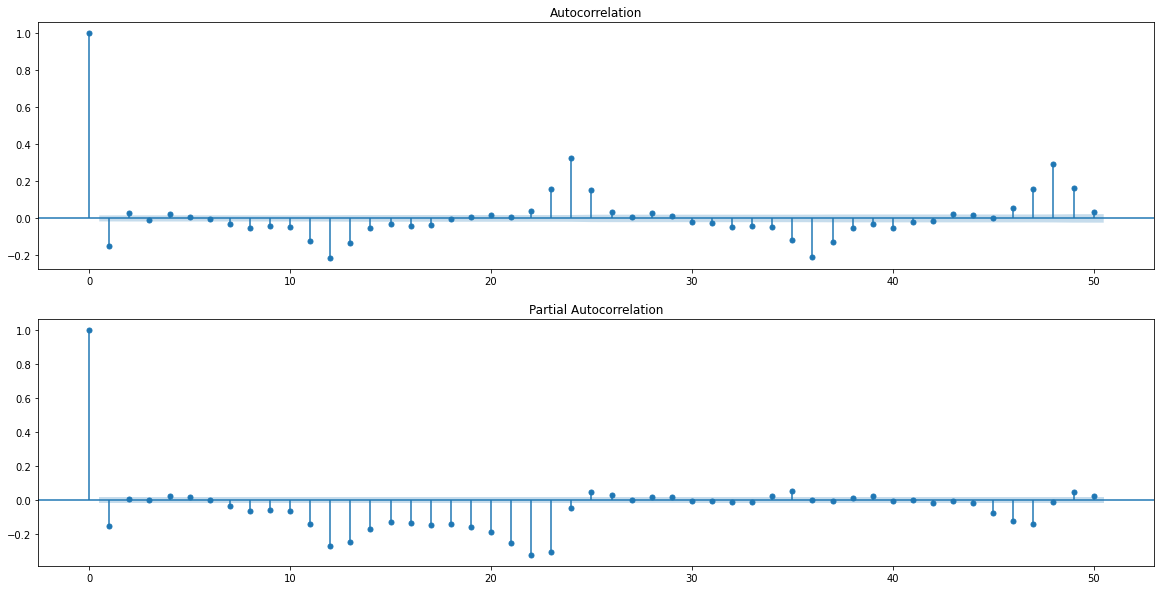

In [18]:
#we use train.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 24 periods, indicating a daily pattern exists, and from previous modeling (day) we already know that there's also a strong weekly pattern, which makes it 24*7=168.

In [19]:
#need to change working directory to figure so we can save the figures in its folder
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

# TBATS
From modeling the daily sales data, TBATS was able to capture both weekly and yearly seaonsality, now that the data will be in hourly form, so the seasonal_periods=(24, 168)

In [20]:
# Fit the model, seasonal_periods=(24, 168) for two seasonalities, 24 for daily and 168 for weekly
# model computation may take way too long for yearly
start = time.time()
tbats = TBATS(seasonal_periods=(24, 168)).fit(train)
end = time.time()
fit_time = (end-start)
fit_time

1224.7704753875732

In [21]:
fit_time_per_row = round(fit_time/len(train),4)
fit_time_per_row

0.0842

In [22]:
# forecast and save it to a df
pred = tbats.forecast(steps=(len(test)+8736))
TBATS_pred = pd.DataFrame({
    'pred': pred,
}, index=pd.date_range('2017-09-01', periods=len(pred), freq='h'))
TBATS_pred

,pred
2017-09-01 00:00:00,-1.650489
2017-09-01 01:00:00,0.420869
2017-09-01 02:00:00,2.265383
2017-09-01 03:00:00,3.277668
2017-09-01 04:00:00,4.518192
...,...
2018-12-30 19:00:00,104.882596
2018-12-30 20:00:00,109.808152
2018-12-30 21:00:00,113.269114
2018-12-30 22:00:00,85.778846


In [23]:
# since we know the actual store hours, we will modify the results such that all the sales at closed store hours will be 0
# we will make a function that takes in a dataframe with datetime index and change the values to 0s according to the time
def store_hour(dataframe):
    for i in range(11): # to select hours from midnight to 10 am, which the store is closed 7 days a week
        dataframe.loc[dataframe.index.hour==i]=0
# then change Sun~Thu's 11pm to 0
    for dow in [0,1,2,3,6]: #all day of week except friday and saturday, since store open until midnight
        dataframe.loc[(dataframe.index.hour==23) & (dataframe.index.weekday==dow)]=0
    return dataframe

In [24]:
TBATS_pred = store_hour(TBATS_pred)
TBATS_pred #check and see if the func works

,pred
2017-09-01 00:00:00,0.000000
2017-09-01 01:00:00,0.000000
2017-09-01 02:00:00,0.000000
2017-09-01 03:00:00,0.000000
2017-09-01 04:00:00,0.000000
...,...
2018-12-30 19:00:00,104.882596
2018-12-30 20:00:00,109.808152
2018-12-30 21:00:00,113.269114
2018-12-30 22:00:00,85.778846


In [25]:
#save the prediction to csv file so we can load it instead of running the model all the time.
TBATS_pred.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred_9_1_2017.csv',
                index=True)

In [26]:
# load the prediction file
TBATS_pred = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred_9_1_2017.csv',
                        index_col=[0])
TBATS_pred.head()

,pred
2017-09-01 00:00:00,0.0
2017-09-01 01:00:00,0.0
2017-09-01 02:00:00,0.0
2017-09-01 03:00:00,0.0
2017-09-01 04:00:00,0.0


In [27]:
#create a dataframe to record and save the scores as csv as well as its predicitons
TBATS_hourly_df = pd.DataFrame({
    'model':'TBATS-hourly',
    'RMSE':mean_squared_error(test,TBATS_pred[:len(test)], squared=False),
    'MAE':mean_absolute_error(test,TBATS_pred[:len(test)]),
    '2018RMSE':mean_squared_error(baseline,TBATS_pred[len(test):], squared=False),
    '2018MAE':mean_absolute_error(baseline,TBATS_pred[len(test):]),
    'fit_time_per_row': fit_time_per_row,
}, index=[0])
TBATS_hourly_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly.csv',
                index=False)
TBATS_hourly_df

,model,RMSE,MAE,2018RMSE,2018MAE,fit_time_per_row
0,TBATS-hourly,30.409302,17.096527,21.063152,11.989361,0.0842


In [28]:
#load the csv
TBATS_hourly_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly.csv')
TBATS_hourly_df

,model,RMSE,MAE,2018RMSE,2018MAE,fit_time_per_row
0,TBATS-hourly,30.409302,17.096527,21.063152,11.989361,0.0842


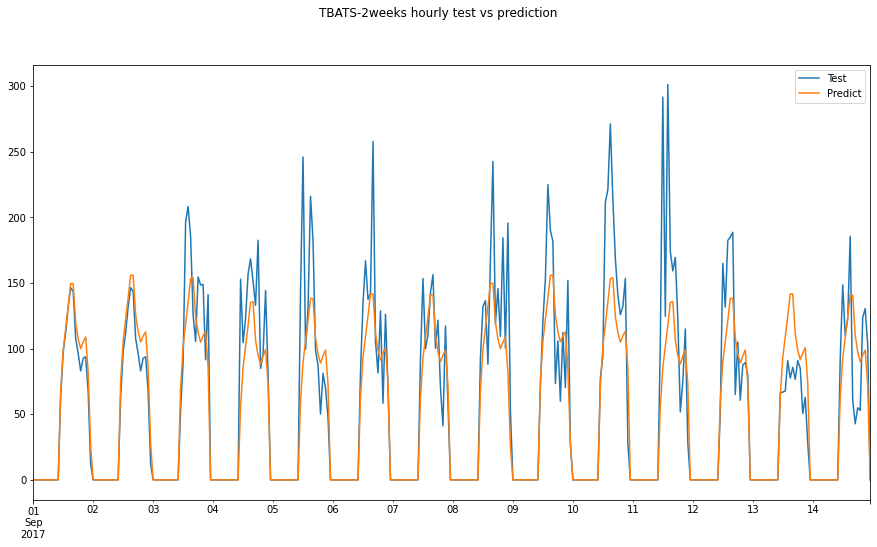

In [29]:
#view the plot of test vs pred first 2 weeks of sep
pd.DataFrame({'test':test[:(24*7*2)],'pred':TBATS_pred.pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('TBATS-2weeks hourly test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_sep1to14_test_pred.png')
plt.show()

The daily periodicity is obvious, but the weekly isn't that obvious.

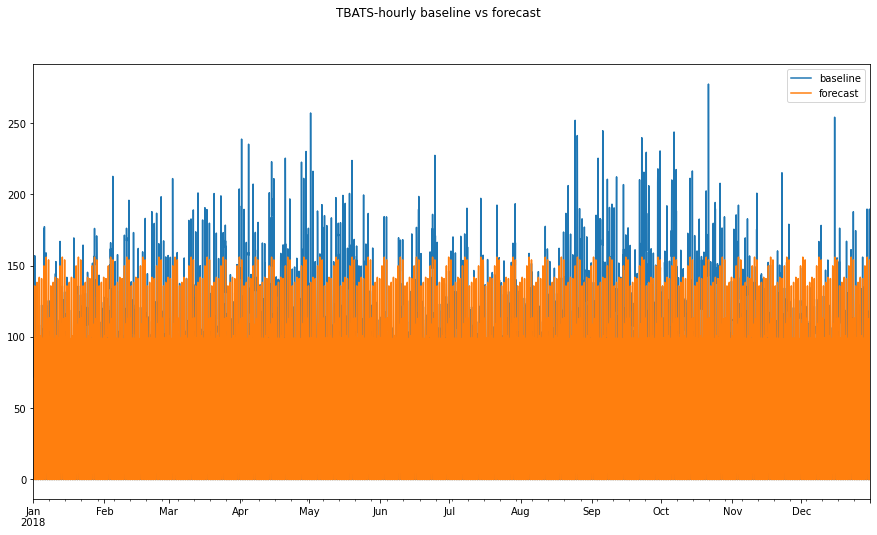

In [30]:
#view the 2018 forecast
pd.DataFrame({'baseline':baseline, 'forecast':TBATS_pred.pred[(len(test)):]}).plot(figsize=(15,8))
plt.suptitle('TBATS-hourly baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('TBATS_hourly_baseline_forecast.png')
plt.show()

Doesn't look like there are any yearly seasonality, which is fine since we did not input 8760 for yearly seasonality. Overall, it's not too great, since it doesn't really capture the weekly periodicity.

# TBATS with daily, weekly, and yearly seasonality
we will use 2016 and 2017 as training data, and baseline 2018 as testing

In [32]:
# Fit the model, seasonal_periods=(24, 168)
start = time.time()
tbats_y = TBATS(seasonal_periods=(24, 168)).fit(dfts24['sales']) #training data dfts24 = 2016 and 2017
end = time.time()
fit_time = (end-start)
fit_time_per_row = round(fit_time/len(dfts24),4)
fit_time_per_row

0.0821

In [33]:
# get the predictions
pred = tbats_y.forecast(steps=(364*24)) # next 52 weeks (364 days x 24 hours) of data from starting from Monday
# turn it to dataframe with correct index as time series
TBATSY_pred = pd.DataFrame({
    'pred': pred,
}, index=pd.date_range('2018-01-01', periods=len(pred), freq='h'))
# clean the prediction according to store hours
TBATSY_pred = store_hour(TBATSY_pred)
#save the prediction to csv file so we can load it instead of running the model all the time.
TBATSY_pred.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred2018.csv',
                index=True)
# view
TBATSY_pred.tail()

,pred
2018-12-30 19:00:00,86.284954
2018-12-30 20:00:00,92.848084
2018-12-30 21:00:00,95.170655
2018-12-30 22:00:00,68.356543
2018-12-30 23:00:00,0.000000


In [34]:
#load the prediction file
TBATSY_pred = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred2018.csv',
                index_col=[0])
TBATSY_pred.tail()

,pred
2018-12-30 19:00:00,86.284954
2018-12-30 20:00:00,92.848084
2018-12-30 21:00:00,95.170655
2018-12-30 22:00:00,68.356543
2018-12-30 23:00:00,0.000000


In [35]:
#create a dataframe to record and save model metrics as csv
TBATSY_hourly_df = pd.DataFrame({
    'model':'TBATS-hourlyY',
    '2018RMSE':mean_squared_error(bl_df,TBATSY_pred.pred, squared=False),
    '2018MAE':mean_absolute_error(bl_df,TBATSY_pred.pred),
    'fit_time_per_row': fit_time_per_row,
}, index=[0])

TBATSY_hourly_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourlyY.csv',
                index=False)
TBATSY_hourly_df

,model,2018RMSE,2018MAE,fit_time_per_row
0,TBATS-hourlyY,21.481831,11.869899,0.0821


In [36]:
# read the file
TBATSY_hourly_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourlyY.csv')
TBATSY_hourly_df

,model,2018RMSE,2018MAE,fit_time_per_row
0,TBATS-hourlyY,21.481831,11.869899,0.0821


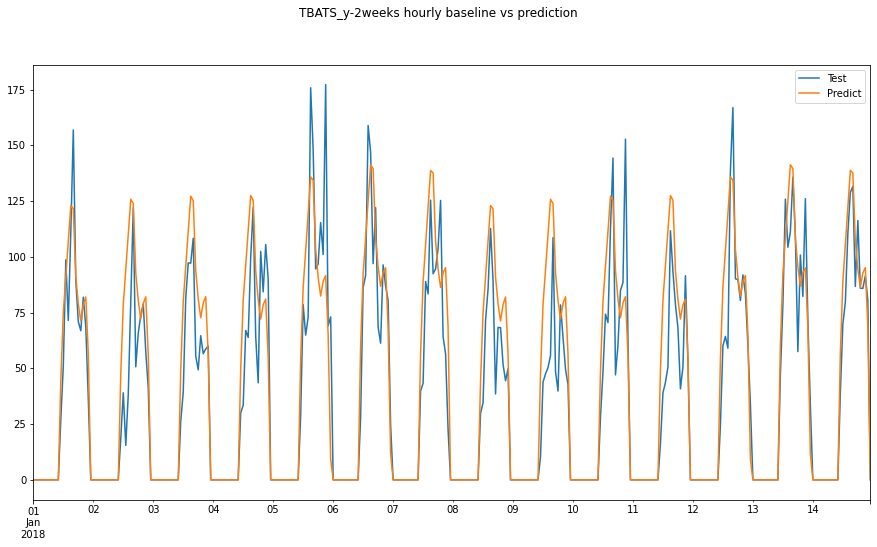

In [37]:
#view the plot of test vs pred first 2 weeks of baseline
pd.DataFrame({'basline':bl_df[:(24*7*2)],'pred':TBATSY_pred.pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('TBATS_y-2weeks hourly baseline vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_y_sep1to14_baseline_pred.png')

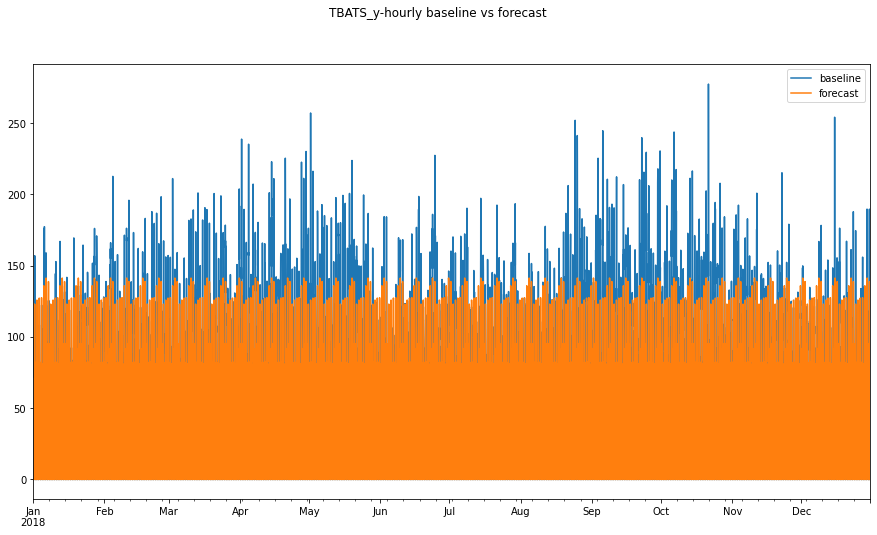

In [38]:
#view the 2018 forecast
pd.DataFrame({'baseline':bl_df, 'forecast':TBATSY_pred.pred}).plot(figsize=(15,8))
plt.suptitle('TBATS_y-hourly baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('TBATS_y_hourly_baseline_forecast.png')

The peak months are wrong! We're better off without the yearly seasonality hypter parameter.

# TBATS train2016 test2017
since auto arima demands large amount of time and memory, I used 2016 as training data and 2017 as test. Thus I'll need to do the same with TBATS model to compare with other models.

In [42]:
# Fit the model, seasonal_periods=(24, 168) no yearly because we only trained 1 year of data
start = time.time() #time how long it'll take to fit/train
tbats2017 = TBATS(seasonal_periods=(24, 168)).fit(dfts2016['sales']) #train
end = time.time()
fit_time = (end-start)
fit_time_per_row = round(fit_time/len(dfts2016.sales),4)

In [53]:
# get the predictions
pred = tbats2017.forecast(steps=(364*24)) # next 52 weeks (364 days x 24 hours) of data from starting from Monday
# turn it to dataframe with correct index as time series
TBATS_pred2017 = pd.DataFrame({
    'pred': pred,
}, index=pd.date_range('2017-01-02', periods=len(pred), freq='h'))
# clean the prediction according to store hours
TBATS_pred2017 = store_hour(TBATS_pred2017)
#save the prediction to csv file so we can load it instead of running the model all the time.
TBATS_pred2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred2017.csv',
                index=True)

In [57]:
#create a dataframe to record and save model metrics as csv
TBATS_hourly2017 = pd.DataFrame({
    'model':'TBATS-hourly2017',
    '2017RMSE':mean_squared_error(dfts2017.sales,TBATS_pred2017.pred, squared=False),
    '2017MAE':mean_absolute_error(dfts2017.sales,TBATS_pred2017.pred),
    'fit_time_per_row': fit_time_per_row,
}, index=[0])
# save as csv file
TBATS_hourly2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly2017.csv',
                index=False)

In [58]:
#load the prediction file
TBATS_pred2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred2017.csv',
                index_col=[0])
TBATS_pred2017.tail()

,pred
2017-12-31 19:00:00,98.205324
2017-12-31 20:00:00,102.234104
2017-12-31 21:00:00,104.811941
2017-12-31 22:00:00,79.450661
2017-12-31 23:00:00,0.000000


In [59]:
# load the model score
TBATS_hourly2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly2017.csv')
TBATS_hourly2017

,model,2017RMSE,2017MAE,fit_time_per_row
0,TBATS-hourly2017,28.53875,15.545161,0.0849


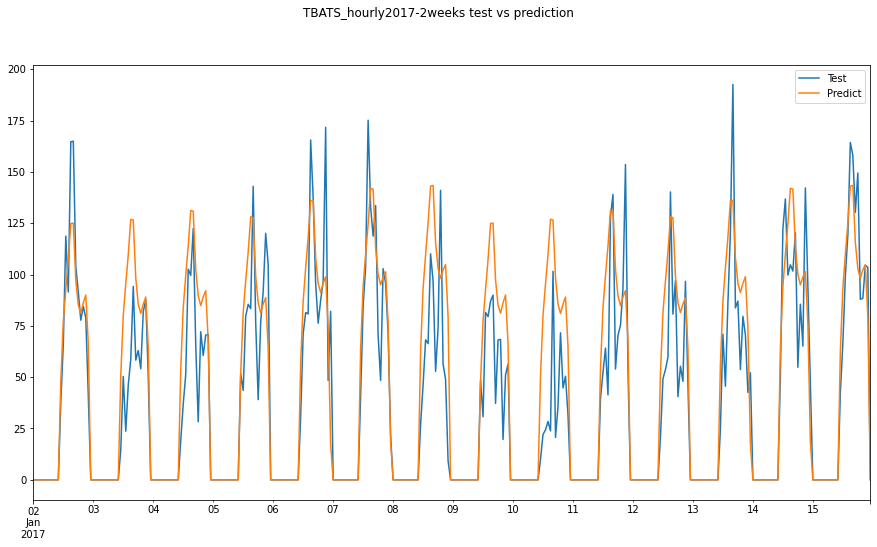

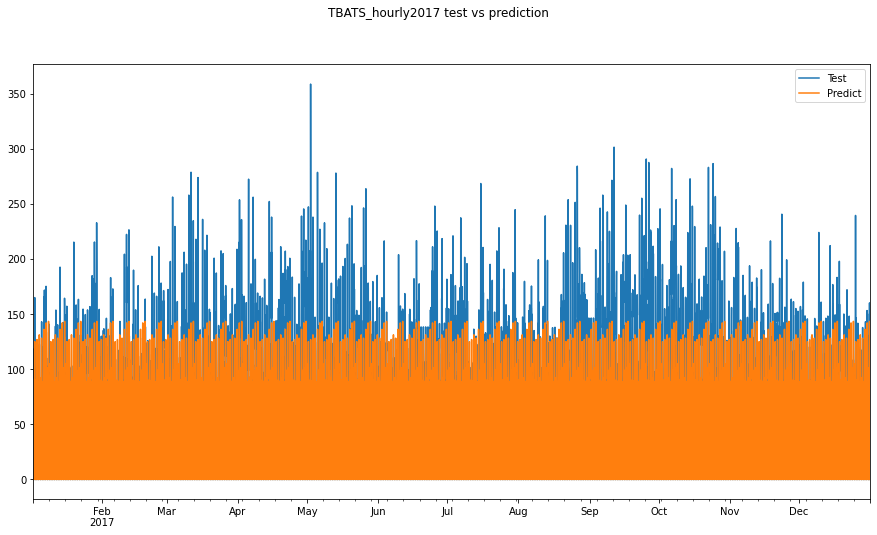

In [60]:
#view the plot of test vs pred first 2 weeks
pd.DataFrame({'test':dfts2017.sales[:(24*7*2)],'pred':TBATS_pred2017.pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('TBATS_hourly2017-2weeks test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_hourly2017-2weeks test vs prediction.png')
#view the 2018 forecast
pd.DataFrame({'test':dfts2017.sales, 'forecast':TBATS_pred2017.pred}).plot(figsize=(15,8))
plt.suptitle('TBATS_hourly2017 test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_hourly2017 test vs prediction.png')

# auto_arima with exog features: Day of Week, Hour of Day, and Month
previously I tried adding fourier term as exog, the results were way off, and the fit time was very long. So we will stick with these 3.

In [64]:
# prep the exog
exog = pd.concat([dfts2016, dfts2017])
# month one hot encoding
exog['month'] = exog.index.month
month_dummies = pd.get_dummies(exog['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
exog = pd.concat([exog, month_dummies], axis=1).drop(['month'],axis=1)
# dayofweek one hot encoding
exog['DoW'] = exog.index.weekday
week_dummies = pd.get_dummies(exog['DoW'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
exog = pd.concat([exog, week_dummies], axis=1).drop(['DoW'],axis=1)
# hour of day one hot encoding
exog['HoD'] = exog.index.hour
hour_dummies = pd.get_dummies(exog['HoD'])
hour_dummies.columns = [str(i) for i in range(24)]
exog = pd.concat([exog, hour_dummies], axis=1).drop(['HoD'],axis=1)
exog = exog.drop(columns=['sales'])

In [65]:
# due to runtime and memory problem, we will use 2016 data as train, and 2017 as test
#set the train & test data
train = dfts2016.sales
test = dfts2017.sales
#set the exog which are the same since we always start with Monday at 00 hour
exog_to_train = exog.iloc[:(364*24)]
exog_to_test = exog.iloc[(364*24):]
# run the auto_arima and time it
start = time.time()
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)
end = time.time()
fit_time = end-start
fit_time_per_row = round(fit_time/len(train),4)
fit_time_per_row

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

1.2739

In [66]:
# forecast
pred = AA_model.predict(n_periods=(len(test)), exogenous=exog_to_test)
# turn it to dataframe with correct index as time series
AA3X_hourly_pred2017 = pd.DataFrame({
    'pred': pred,
}, index=pd.date_range('2017-01-02', periods=len(pred), freq='h'))
# clean the prediction according to store hours
AA3X_hourly_pred2017 = store_hour(AA3X_hourly_pred2017)
#save the prediction as csv
AA3X_hourly_pred2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3X_hourly_pred2017.csv',
                index=True)

In [69]:
#create a dataframe to record and save model metrics as csv
AA3X_hourly2017 = pd.DataFrame({
    'model':'AA3X-hourly',
    '2017RMSE':mean_squared_error(test, AA3X_hourly_pred2017.pred, squared=False),
    '2017MAE':mean_absolute_error(test, AA3X_hourly_pred2017.pred),
    'fit_time_per_row': fit_time_per_row,
}, index=[0])
# save as csv
AA3X_hourly2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3X_hourly2017.csv',
                index=False)

In [70]:
# load the prediction
AA3X_hourly_pred2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3X_hourly_pred2017.csv',
                          index_col=[0])
AA3X_hourly_pred2017.tail()

,pred
2017-12-31 19:00:00,90.738770
2017-12-31 20:00:00,94.736328
2017-12-31 21:00:00,98.425293
2017-12-31 22:00:00,72.883301
2017-12-31 23:00:00,0.000000


In [71]:
# load the model score
AA3X_hourly2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3X_hourly2017.csv')
AA3X_hourly2017

,model,2017RMSE,2017MAE,fit_time_per_row
0,AA3X-hourly,28.208743,15.430962,1.2739


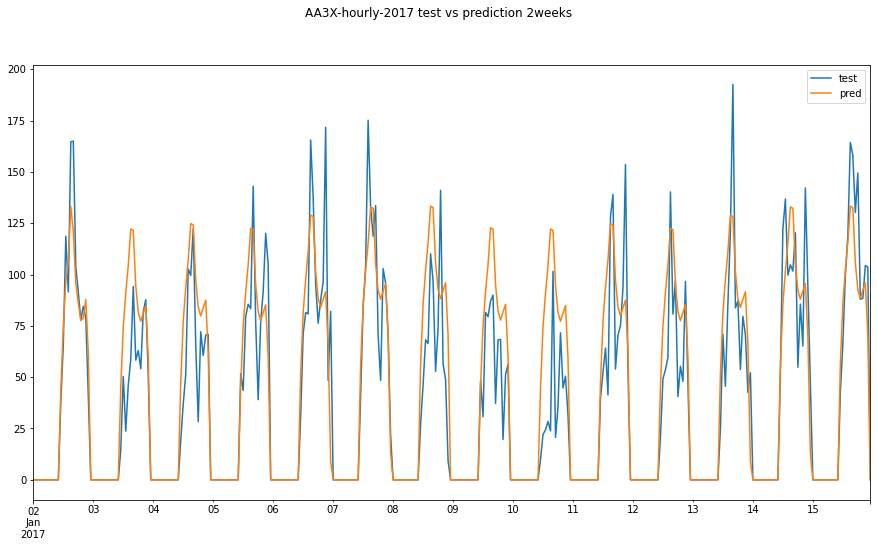

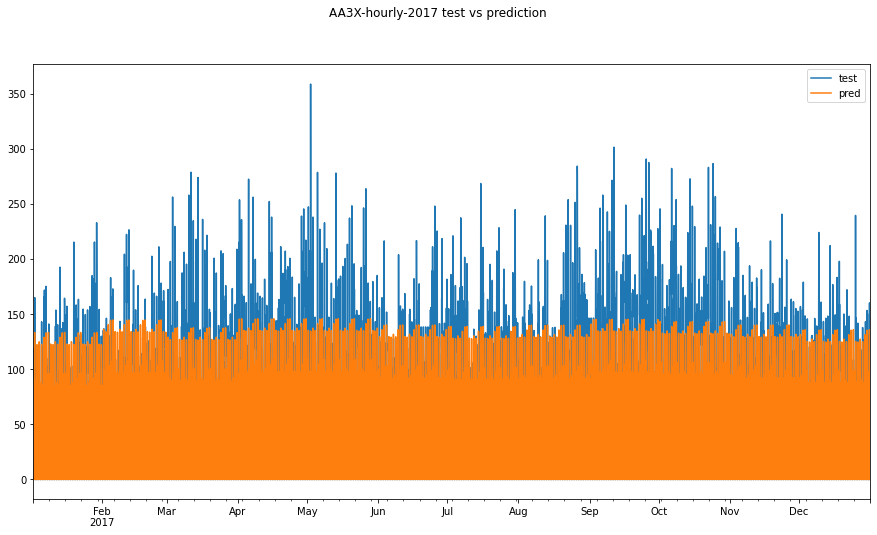

In [72]:
#get the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test[:(24*7*2)],'pred':AA3X_hourly_pred2017.pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('AA3X-hourly-2017 test vs prediction 2weeks')
plt.legend(["test", "pred"])
plt.savefig('AA3X-hourly-2017 test vs prediction 2weeks.png')
#view the 2017 forecast
pd.DataFrame({'test':test, 'pred':AA3X_hourly_pred2017.pred}).plot(figsize=(15,8))
plt.suptitle('AA3X-hourly-2017 test vs prediction')
plt.legend(["test", "pred"])
plt.savefig('AA3X-hourly-2017 test vs prediction.png')

# AA3N (normalized exog)
Using regular dummies will took too much time/memory, we will redo the dummies by allocating the normalized value of mentioned features. By its mean, e.g. if March was the best month, it'll be 1, and other months will be its mean divide by March's mean.

In [76]:
# get the mean of wanted values
monthly2016 = dfts2016.sales.groupby(dfts2016.index.month).mean()
hourly2016 = dfts2016.sales.groupby(dfts2016.index.hour).mean()
dow2016 = dfts2016.sales.groupby(dfts2016.index.weekday).mean()
display(monthly2016.head(3))
display(hourly2016.head(3))
display(dow2016.head(3))

1    42.630027
2    53.455925
3    46.049949
Name: sales, dtype: float64

0    0.0
1    0.0
2    0.0
Name: sales, dtype: float64

0    45.189601
1    45.466166
2    47.644199
Name: sales, dtype: float64

In [77]:
exog = pd.concat([dfts2016, dfts2017])
#setting the normalized values of given month/HoD/DoW based on the max of its mean
exog['month'] = exog.index.month
exog['month'].replace([i for i in range(1,13)], [round(monthly2016[i]/monthly2016.max(),2) for i in range(1,13)], inplace=True)
exog['HoD'] = exog.index.hour
exog['HoD'].replace([i for i in range(24)], [round(hourly2016[i]/hourly2016.max(),2) for i in range(24)], inplace=True)
exog['DoW'] = exog.index.weekday
exog['DoW'].replace([i for i in range(7)], [round(dow2016[i]/dow2016.max(),2) for i in range(7)], inplace=True)
exog = exog.drop(columns=['sales'])
display(exog.head(3))
display(exog.tail(3))

,month,HoD,DoW
2016-01-04 00:00:00,0.77,0.0,0.8
2016-01-04 01:00:00,0.77,0.0,0.8
2016-01-04 02:00:00,0.77,0.0,0.8


,month,HoD,DoW
2017-12-31 21:00:00,0.82,0.72,0.99
2017-12-31 22:00:00,0.82,0.53,0.99
2017-12-31 23:00:00,0.82,0.11,0.99


In [78]:
#set the train & test data
train = dfts2016.sales
test = dfts2017.sales
#set the exog which are the same since we always start with Monday at 00 hour
exog_to_train = exog.iloc[:(364*24)]
exog_to_test = exog.iloc[(364*24):]
# run the auto_arima and time it
start = time.time()
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)
end = time.time()
fit_time = end-start
fit_time_per_row = round(fit_time/len(train),4)
fit_time_per_row

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

0.5904

In [79]:
# forecast
pred = AA_model.predict(n_periods=(len(test)), exogenous=exog_to_test)
# turn it to dataframe with correct index as time series
AA3N_hourly_pred2017 = pd.DataFrame({
    'pred': pred,
}, index=pd.date_range('2017-01-02', periods=len(pred), freq='h'))
# clean the prediction according to store hours
AA3N_hourly_pred2017 = store_hour(AA3N_hourly_pred2017)
#save the prediction to csv file so we can load it instead of running the model all the time.
AA3N_hourly_pred2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3N_hourly_pred2017.csv',
                index=True)
#create a dataframe to record and save model metrics as csv
AA3N_hourly2017 = pd.DataFrame({
    'model':'AA3N-hourly',
    '2017RMSE':mean_squared_error(test, AA3N_hourly_pred2017.pred, squared=False),
    '2017MAE':mean_absolute_error(test, AA3N_hourly_pred2017.pred),
    'fit_time_per_row': fit_time_per_row,
}, index=[0])
# save the dataframe to record
AA3N_hourly2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3N_hourly2017.csv',
                index=False)

In [80]:
# load the prediction data
AA3N_hourly_pred2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3N_hourly_pred2017.csv',
                                   index_col=[0])
AA3N_hourly_pred2017.tail()

,pred
2017-12-31 19:00:00,91.378192
2017-12-31 20:00:00,94.061546
2017-12-31 21:00:00,98.086576
2017-12-31 22:00:00,72.594720
2017-12-31 23:00:00,0.000000


In [81]:
# load the model score file
AA3N_hourly2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3N_hourly2017.csv')
AA3N_hourly2017

,model,2017RMSE,2017MAE,fit_time_per_row
0,AA3N-hourly,28.721891,15.685231,0.5904


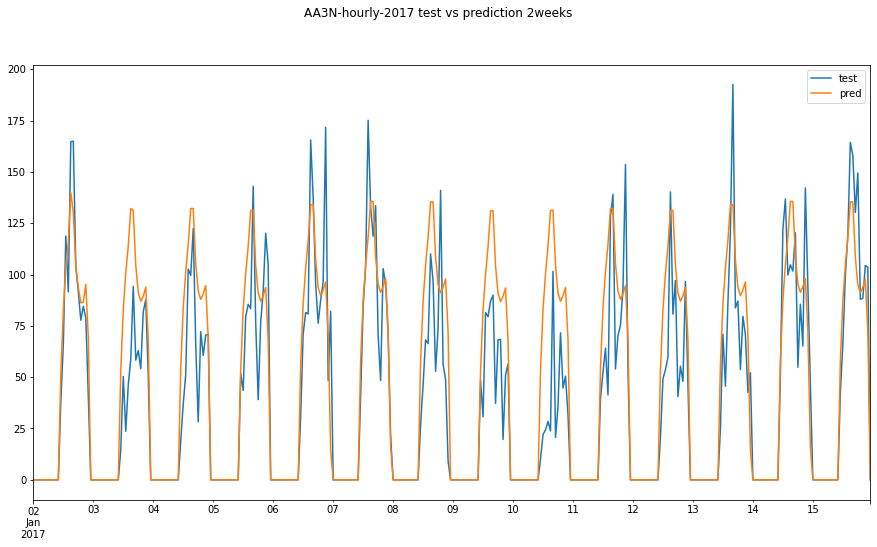

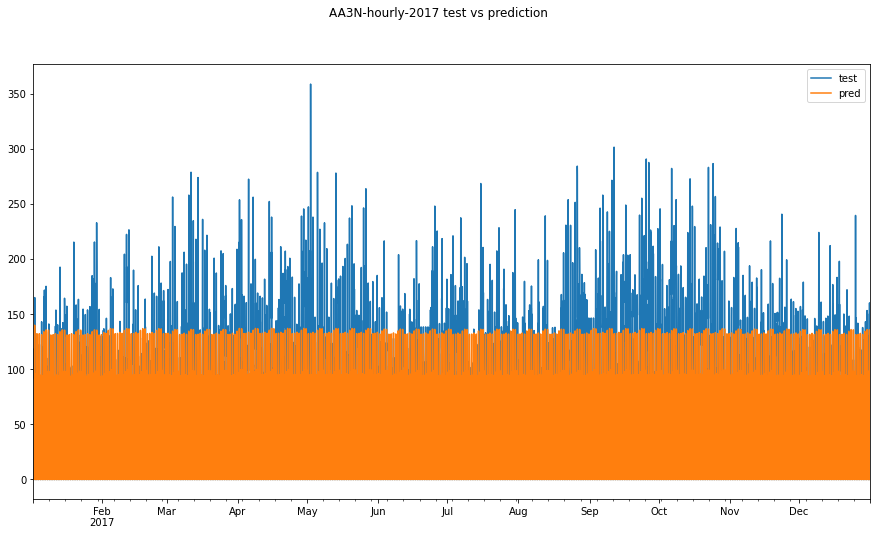

In [82]:
#get the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test[:(24*7*2)],'pred':AA3N_hourly_pred2017.pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('AA3N-hourly-2017 test vs prediction 2weeks')
plt.legend(["test", "pred"])
plt.savefig('AA3N-hourly-2017 test vs prediction 2weeks.png')
#view the 2017 forecast
pd.DataFrame({'test':test, 'pred':AA3N_hourly_pred2017.pred}).plot(figsize=(15,8))
plt.suptitle('AA3N-hourly-2017 test vs prediction')
plt.legend(["test", "pred"])
plt.savefig('AA3N-hourly-2017 test vs prediction.png')

# AA Exog with ranked order for month, DoW. But HoD normalized

In [87]:
# let's take a look at each month's hourly mean
monthly2016.sort_values()

1     42.630027
12    44.934483
3     46.049949
7     48.185520
8     48.530766
6     48.950708
11    48.953594
10    52.317755
2     53.455925
9     54.229417
5     54.545161
4     55.097000
Name: sales, dtype: float64

In [88]:
# since each year should have 3 to 4 seasons, we will break monthly into 3 sales ratings for exog feature
display(monthly2016.quantile(0.67))
display(monthly2016.quantile(0.33))
monthly2016.sort_values()

52.738878085904766

48.40302515022137

1     42.630027
12    44.934483
3     46.049949
7     48.185520
8     48.530766
6     48.950708
11    48.953594
10    52.317755
2     53.455925
9     54.229417
5     54.545161
4     55.097000
Name: sales, dtype: float64

In [89]:
# let's make a quantile based hourly sales by month
monthly2016q = monthly2016.copy()
monthly2016q[1, 12, 3, 7] = 1 #worst sales
monthly2016q[8, 6, 11, 10] = 2 #in between
monthly2016q[2, 9, 5, 4] = 3 #best sales
monthly2016q.sort_values()

1     1.0
3     1.0
7     1.0
12    1.0
6     2.0
8     2.0
10    2.0
11    2.0
2     3.0
4     3.0
5     3.0
9     3.0
Name: sales, dtype: float64

In [90]:
# so let's take a look at day of week
dow2016.sort_values()

0    45.189601
1    45.466166
3    45.686576
2    47.644199
4    52.619622
6    55.824588
5    56.317072
Name: sales, dtype: float64

In [91]:
# it's obvious that friday, saturday and sunday has best sales. Especially saturday and sunday. So we should break it down
# from top to bottom, sat/sun > fri > wed > rest. so we have 4 quantiles
dow2016q = dow2016.copy()
dow2016q[0,1,3] = 1 #worst sales
dow2016q[2] = 2
dow2016q[4] = 3
dow2016q[6,5] = 4 #best sales
dow2016q.sort_values()

0    1.0
1    1.0
3    1.0
2    2.0
4    3.0
5    4.0
6    4.0
Name: sales, dtype: float64

In [94]:
# redo the exog
exog = pd.concat([dfts2016, dfts2017])
# set the month exog
exog['month'] = exog.index.month
exog['month'].replace([3,7,12], 1, inplace=True)
exog['month'].replace([2,4,5,9], 3, inplace=True)
exog['month'].replace([6,8,10,11], 2, inplace=True)
# set the DoW exog
exog['DoW'] = exog.index.weekday
exog['DoW'].replace([0,3], 1, inplace=True) #1 is already 1
# 2 is already 2 no need ot change anything
exog['DoW'].replace(4, 3, inplace=True) # change 4 to 3
exog['DoW'].replace([5,6], 4, inplace=True) # 5 and 6 to 4
# set the HoD exog
exog['HoD'] = exog.index.hour
exog['HoD'].replace([i for i in range(24)], [hourly2016[i]/hourly2016.max() for i in range(24)], inplace=True)
# drop the sales columns
exog=exog.drop(columns=['sales'])
exog

,month,DoW,HoD
2016-01-04 00:00:00,1,1,0.000000
2016-01-04 01:00:00,1,1,0.000000
2016-01-04 02:00:00,1,1,0.000000
2016-01-04 03:00:00,1,1,0.000000
2016-01-04 04:00:00,1,1,0.000000
...,...,...,...
2017-12-31 19:00:00,1,4,0.665007
2017-12-31 20:00:00,1,4,0.694787
2017-12-31 21:00:00,1,4,0.722349
2017-12-31 22:00:00,1,4,0.531965


In [95]:
#set the train & test data
train = dfts2016.sales
test = dfts2017.sales
#set the exog which are the same since we always start with Monday at 00 hour
exog_to_train = exog.iloc[:(364*24)]
exog_to_test = exog.iloc[(364*24):]
# run the auto_arima and time it
start = time.time()
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)
end = time.time()
fit_time = end-start
fit_time_per_row = round(fit_time/len(train),4)
fit_time_per_row

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

0.5217

In [96]:
# forecast
pred = AA_model.predict(n_periods=(len(test)), exogenous=exog_to_test)
# turn it to dataframe with correct index as time series
AA3R_hourly_pred2017 = pd.DataFrame({
    'pred': pred,
}, index=pd.date_range('2017-01-02', periods=len(pred), freq='h'))
# clean the prediction according to store hours
AA3R_hourly_pred2017 = store_hour(AA3R_hourly_pred2017)
#save the prediction to csv file so we can load it instead of running the model all the time.
AA3R_hourly_pred2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3R_hourly_pred2017.csv',
                index=True)
#create a dataframe to record and save model metrics as csv
AA3R_hourly2017 = pd.DataFrame({
    'model':'AA3R-hourly',
    '2017RMSE':mean_squared_error(test, AA3R_hourly_pred2017.pred, squared=False),
    '2017MAE':mean_absolute_error(test, AA3R_hourly_pred2017.pred),
    'fit_time_per_row': fit_time_per_row,
}, index=[0])
# save the dataframe to record
AA3R_hourly2017.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3R_hourly2017.csv',
                index=False)

In [97]:
# load the prediction data
AA3R_hourly_pred2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3R_hourly_pred2017.csv',
                                   index_col=[0])
AA3R_hourly_pred2017.tail()

,pred
2017-12-31 19:00:00,88.999666
2017-12-31 20:00:00,92.946182
2017-12-31 21:00:00,96.598759
2017-12-31 22:00:00,71.368741
2017-12-31 23:00:00,0.000000


In [98]:
# load the model score file
AA3R_hourly2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA3R_hourly2017.csv')
AA3R_hourly2017

,model,2017RMSE,2017MAE,fit_time_per_row
0,AA3R-hourly,28.459946,15.537691,0.5217


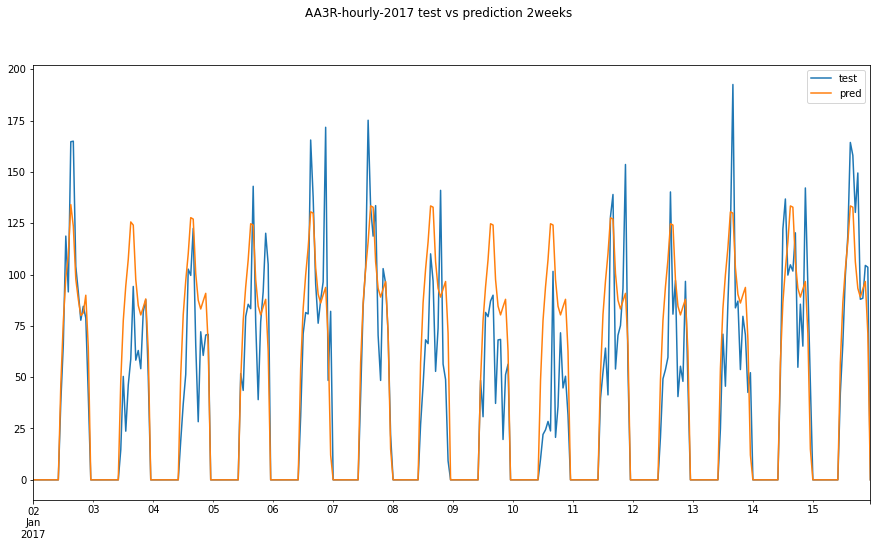

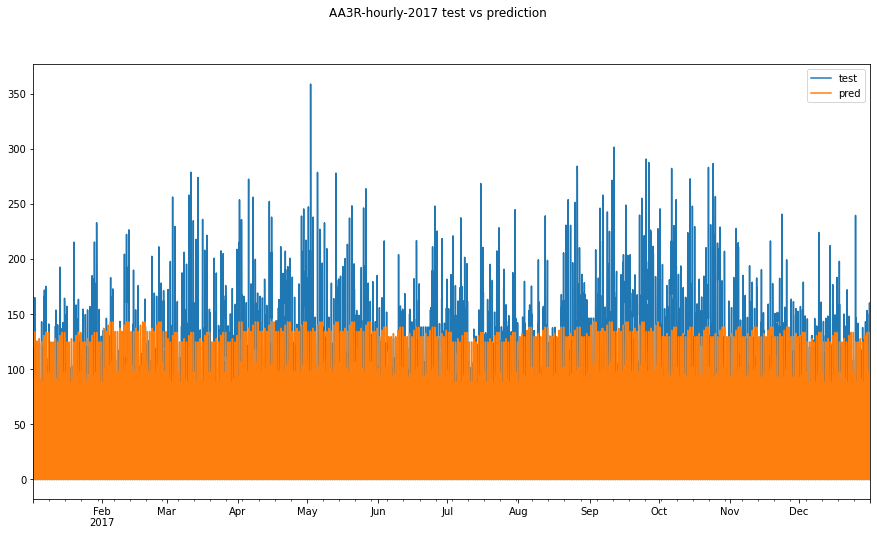

In [99]:
#get the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test[:(24*7*2)],'pred':AA3R_hourly_pred2017.pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('AA3R-hourly-2017 test vs prediction 2weeks')
plt.legend(["test", "pred"])
plt.savefig('AA3R-hourly-2017 test vs prediction 2weeks.png')
#view the 2017 forecast
pd.DataFrame({'test':test, 'pred':AA3R_hourly_pred2017.pred}).plot(figsize=(15,8))
plt.suptitle('AA3R-hourly-2017 test vs prediction')
plt.legend(["test", "pred"])
plt.savefig('AA3R-hourly-2017 test vs prediction.png')

# View current models' score

In [111]:
# let's concat the models' scores and see which one to further explore on
model_scores = pd.concat([TBATS_hourly2017,AA3X_hourly2017, AA3N_hourly2017, AA3R_hourly2017])
model_scores['total_fit_time(min)'] = (model_scores.fit_time_per_row * 24*364/60)
model_scores

,model,2017RMSE,2017MAE,fit_time_per_row,total_fit_time(min)
0,TBATS-hourly2017,28.538750,15.545161,0.0849,12.36144
0,AA3X-hourly,28.208743,15.430962,1.2739,185.47984
0,AA3N-hourly,28.721891,15.685231,0.5904,85.96224
0,AA3R-hourly,28.459946,15.537691,0.5217,75.95952


The scores are very similar, however, there's a huge difference in fitting time! All of the above models had same training data (24 hours x 364 days). But TBATS only took a bit more than 12 minutes to train the model, while the auto_arima models had to take atleast 75 minutes.

# Combining Results of 2 Models
Previously from Model (day) we ha AA_DM2FT2017 as best AA_DM2FT model with 2016 as training and 2017 as test.
We will use its predicitond data to turn it self into a ratio based on weekly basis then multiply it with TBATS_pred to get combined prediction.

In [374]:
# load AA_DM3FT prediction, it had the best ForeMAE score
AA_pred = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_DM2FT_pred2017.csv',
                           index_col = [0])
# change the index to datetime
AA_pred.index = pd.to_datetime(AA_pred.index)
AA_pred

,pred
2017-01-02,920.762862
2017-01-03,879.558023
2017-01-04,918.915978
2017-01-05,867.704524
2017-01-06,1033.590345
...,...
2017-12-27,1008.155202
2017-12-28,959.945066
2017-12-29,1125.502391
2017-12-30,1214.268143


In [375]:
# make an empty list to store the mean of daily sales based on month and year
# we do this instead of monthly sum, because some months have more days and thus higher sum
daily_mean = []
# add the monthly mean of Sep to Dec 2017
for i in range(1,13):
    mean = AA_pred.loc[AA_pred.index.month==i].pred.mean()
    daily_mean.append(round(mean, 2))
daily_mean

[1012.78,
 1283.24,
 1107.15,
 1327.38,
 1307.48,
 1179.49,
 1146.34,
 1160.27,
 1310.29,
 1253.99,
 1182.65,
 1088.22]

In [376]:
# we will have the mean of all these months as ratio 1, and calculate the ratio values
# make an empty list to store monthly sales' ratios
monthly_ratio = []
for i in range(len(daily_mean)):
    ratio = daily_mean[i]/np.array(daily_mean).mean()
    monthly_ratio.append(round(ratio, 4))
monthly_ratio

[0.8464,
 1.0724,
 0.9252,
 1.1093,
 1.0927,
 0.9857,
 0.958,
 0.9696,
 1.095,
 1.048,
 0.9883,
 0.9094]

In [377]:
# let's use TBATS_pred to multiple these ratios then check the MAE/ForeMAE
TBATS_pred = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred2017.csv',
                           index_col = [0])
# change the index to datetime
TBATS_pred.index = pd.date_range('2017-01-02', periods=len(TBATS_pred), freq='h')
TBATS_pred

,pred
2017-01-02 00:00:00,0.000000
2017-01-02 01:00:00,0.000000
2017-01-02 02:00:00,0.000000
2017-01-02 03:00:00,0.000000
2017-01-02 04:00:00,0.000000
...,...
2017-12-31 19:00:00,98.205324
2017-12-31 20:00:00,102.234104
2017-12-31 21:00:00,104.811941
2017-12-31 22:00:00,79.450661


In [380]:
# multiply the ratios but save it to dictionary
# make an empty dict
AA_TBATS_dict={}
for i in range(1,13): #iterate and add the key/values for 2017
    AA_TBATS_dict[i] = TBATS_pred.loc[TBATS_pred.index.month==i] * monthly_ratio[i-1]

In [381]:
# make the dictionary into a dataframe
AA_TBATS_df = pd.concat([pd.DataFrame.from_dict(AA_TBATS_dict[i]) for i in range(1, 13)])
AA_TBATS_df

,pred
2017-01-02 00:00:00,0.000000
2017-01-02 01:00:00,0.000000
2017-01-02 02:00:00,0.000000
2017-01-02 03:00:00,0.000000
2017-01-02 04:00:00,0.000000
...,...
2017-12-31 19:00:00,89.307922
2017-12-31 20:00:00,92.971694
2017-12-31 21:00:00,95.315979
2017-12-31 22:00:00,72.252431


In [382]:
# save the prediction to csv file
AA_TBATS_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_TBATS_pred2017.csv',
                   index=True)

In [385]:
# make a df to save the metric scores
AA_TBATS_score = pd.DataFrame({
    'model':'AA_TBATS2017',
    '2017RMSE':mean_squared_error(test,AA_TBATS_df.pred, squared=False),
    '2017MAE':mean_absolute_error(test,AA_TBATS_df.pred),
    'fit_time_per_row': 'N/A',
}, index=[0])
AA_TBATS_score.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_TBATS_score2017.csv',
                index=False)

In [392]:
#load both files
AA_TBATS_pred = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_TBATS_pred2017.csv',
                           index_col=[0])
AA_TBATS_score = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_TBATS_score2017.csv')
display(AA_TABATS_pred)
AA_TBATS_score

,pred
2017-01-02 00:00:00,0.000000
2017-01-02 01:00:00,0.000000
2017-01-02 02:00:00,0.000000
2017-01-02 03:00:00,0.000000
2017-01-02 04:00:00,0.000000
...,...
2017-12-31 19:00:00,89.307922
2017-12-31 20:00:00,92.971694
2017-12-31 21:00:00,95.315979
2017-12-31 22:00:00,72.252431


,model,2017RMSE,2017MAE,fit_time_per_row
0,AA_TBATS2017,28.118901,15.366706,NaN


In [389]:
# load the TBATS hourly 2017 score to compare
TBATS_hourly2017 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly2017.csv')
TBATS_hourly2017

,model,2017RMSE,2017MAE,fit_time_per_row
0,TBATS-hourly2017,28.53875,15.545161,0.0849


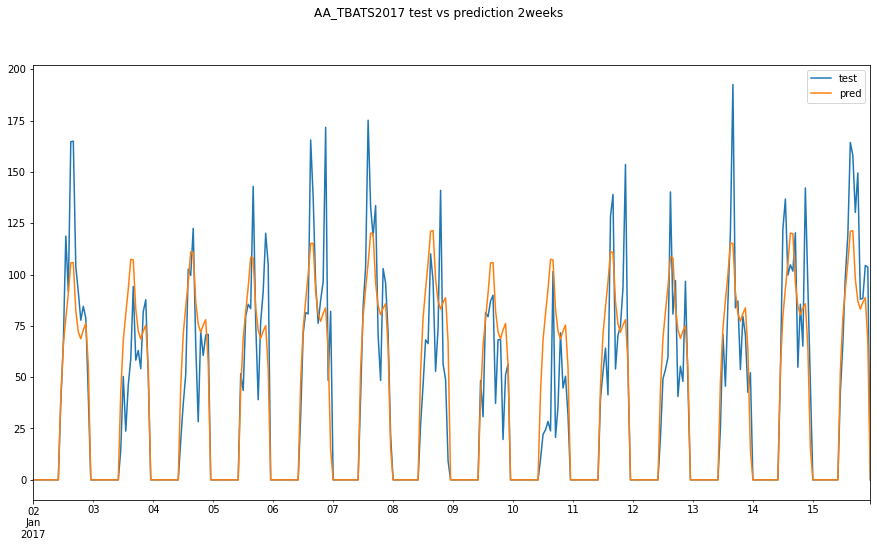

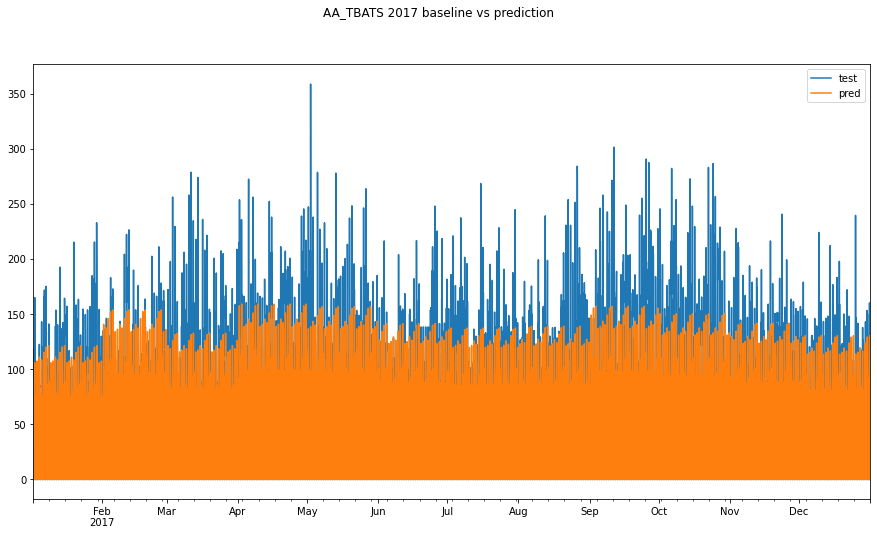

In [393]:
# We can see that there are improvements after the ratio multiplication. Let's view its visuals and see
#the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test[:14*24],'pred':AA_TBATS_pred.pred[:14*24]}).plot(figsize=(15,8))
plt.suptitle('AA_TBATS2017 test vs prediction 2weeks')
plt.legend(["test", "pred"])
plt.savefig('AA_TBATS2017 test vs prediction 2weeks.png')
#view the 2018 forecast
pd.DataFrame({'test':test, 'pred':AA_TBATS_pred.pred}).plot(figsize=(15,8))
plt.suptitle('AA_TBATS 2017 baseline vs prediction')
plt.legend(["test", "pred"])
plt.savefig('AA_TBATS 2017 baseline vs prediction.png')

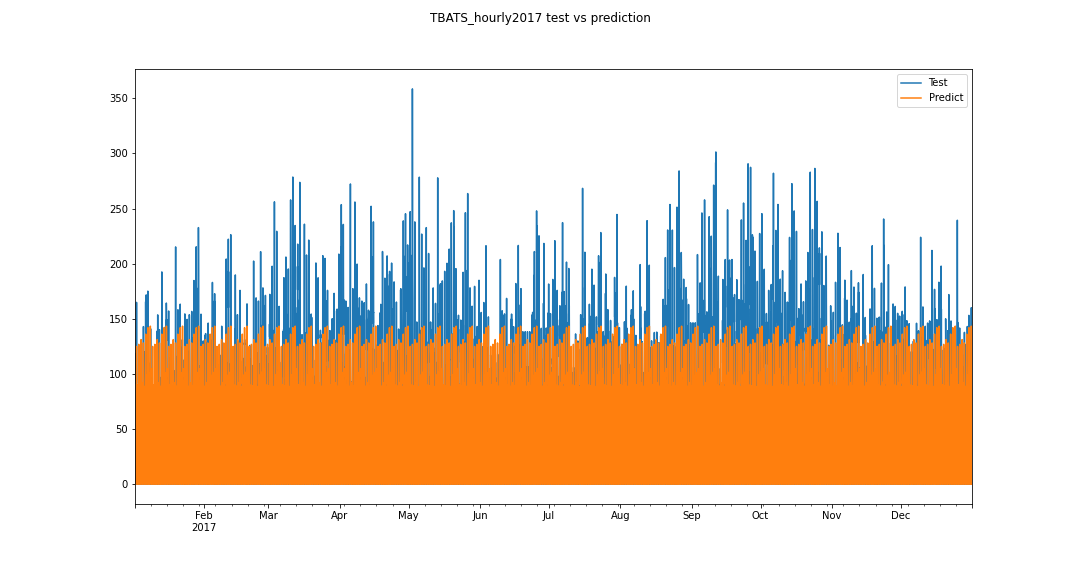

In [396]:
# compare with original 2017 TBATS visual with same train/test data set
Image('TBATS_hourly2017 test vs prediction.png')

Even though the MAE and RMSE only had slight improvements, from the visuals, we can see that implementing the ratio multipler captures the yearly seasonality very well!